In [3]:
%matplotlib inline

from numpy import arange,zeros,mean
import matplotlib.pyplot as plt
import networkx as nx
import pickle
#import random
#from math import floor, ceil

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, Aer, execute
#from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *

### We first define functions for creating graphs

In [2]:
def create_graph_regular(n,d,seed=0):
    G = nx.random_regular_graph(d,n,seed=seed)
    return G

def create_graph_erdos(n,p,seed=0):
    G = nx.erdos_renyi_graph(n,p,seed=seed)
    return G

def create_graph_complete(n):
    G = nx.complete_graph(n)
    return G

### Now we create the different ansatz - the traditional QAOA, and the proposed edge coloring and dfs based ansatz

The logic behind finding the error probability is:

1) Ideally, in the absence of noise if we start from the state $\psi = |0>^{\otimes n}$, and operate some unitary $U$, and its inverse $U^{\dagger}$, then we get the outcome $|0>^{\otimes n}$ with probability 1.

2) However, in the presence of noise, starting with the state $\psi = |0>^{\otimes n}$ and operating $U$ and $U^{\dagger}$ sequentially is most likely not going to return the state $\psi$ with probability 1. Instead, we end up with some state $\propto \psi_e$, where $\psi_e$ is the superposition of $\psi$, as well as other states created due to error. The probability of no error is, then, defined as $|<\psi|\psi_e>|^2$.

Now, when we execute $UU^{\dagger}$, we are increasing the depth, number of CNOT gates, as well as the savings in CNOT gate by a factor of 2. Therefore, we find the probability of no error in the code, we divide $|<\psi|\psi_e>|^2$ by 2 and report the value.

In each of the ansatz henceforth, we first operate the gate operations for the ansatz, and then operate the adjoint of it (i.e., undo everything).

The traditional QAOA ansatz is, from a birds eye view, composed of three sections: the operator $H^{\otimes n}$ that creates the equal superposition, the operator $exp(-i\gamma H_P)$ corresponding to the cost Hamiltonian, and finally the operator $exp(-i \beta H_C)$ corresponding to the mixer Hamiltonian. However, the optimization proposed in the paper optimizes the circuit for cost Hamiltonian only. Furthermore, since we are only interested in finding $|<\psi|\psi_e>|^2$, we have ignored the mixer Hamiltonian portion in the code. This is acceptable, since both in the original, and the proposed ansatz, the mixer Hamiltonian remains unchanged, both will equally suffer for this portion of the circuit. Therefore, we ignore this portion in the code.

#### First we create the traditional QAOA ansatz

In [3]:
def qaoa_ansatz(qc,G,gamma):
    n = len(G.nodes)
    
    for i in G.nodes:
        qc.h(i)
    
    for edge in G.edges:
        qc.cx(edge[0],edge[1])
        qc.rz(gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    # Now undoing everything
    for edge in reversed(list(G.edges)):
        qc.cx(edge[0],edge[1])
        qc.rz(-1*gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    for i in G.nodes:
        qc.h(i)
    
    qc.measure_all()

#### Now we create the optimized ansatz based on Edge Coloring Technique

In [4]:
def edge_col(edges):
    col_dict = {}
    used = {}
    
    c = 1
    col_dict['col'+str(c)] = []
    used['col'+str(c)] = []
    
    for e in edges:
        opted = False
        colors = col_dict.keys()
        for col in colors:
            if e[0] in used[col] or e[1] in used[col]:
                continue
            else:
                col_dict[col].append(e)
                used[col].append(e[0])
                used[col].append(e[1])
                opted = True
        if not opted:
            c = c+1
            new_col = 'col'+str(c)
            col_dict[new_col] = []
            col_dict[new_col].append(e)
            used[new_col] = []
            used[new_col].append(e[0])
            used[new_col].append(e[1])
    
    return col_dict

In [5]:
def get_parallel_edges(G):
    col = []
    used = []
    
    for edge in G.edges:
        if edge[0] not in used and edge[1] not in used:
            col.append(edge)
            used.append(edge[0])
            used.append(edge[1])
    
    return col

In [6]:
def col_ansatz(qc,G,gamma):
    n = len(G.nodes)
    
    opt_edges = get_parallel_edges(G)
    noopt_edges = []
    
    for edge in G.edges:
        if (edge[0],edge[1]) not in opt_edges and (edge[1],edge[0]) not in opt_edges:
            noopt_edges.append(edge)
    
    #print(opt_edges)
    #print(noopt_edges)
    
    for i in G.nodes:
        qc.h(i)
    
    #optimized edges
    for edge in opt_edges:
        qc.rz(gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    #remaining edges
    for edge in noopt_edges:
        qc.cx(edge[0],edge[1])
        qc.rz(gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    
    qc.barrier()
    
    # Now undoing everything
    for edge in reversed(noopt_edges):
        qc.cx(edge[0],edge[1])
        qc.rz(-1*gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    for edge in reversed(opt_edges):
        qc.cx(edge[0],edge[1])
        qc.rz(-1*gamma,edge[1])
    
    for i in G.nodes:
        qc.h(i)
    
    qc.measure_all()

#### Now we create the optimized ansatz based on DFS technique

In [7]:
def get_opt_edges(G):
    visited = []
    to_opt = []
    
    for edges in list(nx.dfs_edges(G,0)):
        if edges[0] not in visited and edges[1] not in visited:
            to_opt.append(edges)
            visited.append(edges[0])
            visited.append(edges[1])
        if edges[0] in visited and edges[1] not in visited:
            to_opt.append(edges)
            visited.append(edges[1])
    
    return to_opt

In [8]:
def dfs_ansatz(qc,G,gamma):
    n = len(G.nodes)
    
    opt_edges = get_opt_edges(G)
    
    noopt_edges = []
    
    for edge in G.edges:
        if (edge[0],edge[1]) not in opt_edges and (edge[1],edge[0]) not in opt_edges:
            noopt_edges.append(edge)
    
    no_opt_order = edge_col(noopt_edges)
    
    for i in G.nodes:
        qc.h(i)
    
    #optimized edges
    for edge in opt_edges:
        qc.rz(gamma,edge[1])
        qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    #non-optimized edges
    
    for color in no_opt_order:
        for edge in no_opt_order[color]:
            qc.cx(edge[0],edge[1])
            qc.rz(gamma,edge[1])
            qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    # Now undoing everything
    for color in reversed(no_opt_order):
        for edge in no_opt_order[color]:
            qc.cx(edge[0],edge[1])
            qc.rz(-1*gamma,edge[1])
            qc.cx(edge[0],edge[1])
    
    qc.barrier()
    
    for edge in reversed(opt_edges):
        qc.cx(edge[0],edge[1])
        qc.rz(-1*gamma,edge[1])
    
    for i in G.nodes:
        qc.h(i)
    
    qc.measure_all()

#### Now we load the noise model from Manhattan Device. This noise model is available in the backend information of the qiskit devices as a json file. We have created a pickle file to avoid json parser, but one can use json file as well.

In [9]:
make_noise = pickle.load(open('noise_model_FakeManhattan.pkl','rb'))

Now some general definition of array, range of nodes etc.

In [10]:
num_vertices = arange(4,13,1)

coloring_scheme = []
dfs_scheme = []
qaoa_scheme = []

trials = 20
shots = 8192

gamma = 0.57

Here we determine the probability of error for each of the three ansatz design technique. Then we find the probability of no error, which is 1 - probability of error. It is not necessary to do this in two steps. One can, simply, calculate the probability of no error only.

In [ ]:
for n in num_vertices:
    G = create_graph_complete(n)
    temp_col = 0
    temp_dfs = 0
    temp_qaoa = 0
    
    for i in range(trials):
        qc_col = QuantumCircuit(n)
        col_ansatz(qc_col,G,gamma)
        
        count_col = execute(qc_col,backend=Aer.get_backend('qasm_simulator'),shots=shots,noise_model=make_noise).result().get_counts()
        temp_col += 0.5*(1 - float(count_col['0'*n]/shots))
        #n_col += float(temp_col/trials)
    coloring_scheme.append(float(temp_col/trials))
    
    # Now the dfs scheme
    for i in range(trials):
        qc_dfs = QuantumCircuit(n)
        dfs_ansatz(qc_dfs,G,gamma)
        
        count_dfs = execute(qc_dfs,backend=Aer.get_backend('qasm_simulator'),shots=shots,noise_model=make_noise).result().get_counts()
        temp_dfs += 0.5*(1 - float(count_dfs['0'*n]/shots))
        #n_dfs += float(temp_dfs/trials)
    dfs_scheme.append(float(temp_dfs/trials))
        
    # Now for the unoptimized scheme
    for i in range(trials):
        qc_qaoa = QuantumCircuit(n)
        qaoa_ansatz(qc_qaoa,G,gamma)
        
        count_qaoa = execute(qc_qaoa,backend=Aer.get_backend('qasm_simulator'),shots=shots,noise_model=make_noise).result().get_counts()
        temp_qaoa += 0.5*(1 - float(count_qaoa['0'*n]/shots))
        #n_qaoa += float(temp_qaoa/trials)
    qaoa_scheme.append(float(temp_qaoa/trials))
    
    print('Completed num_vertex: ',n)

Completed num_vertex:  4
Completed num_vertex:  5
Completed num_vertex:  6
Completed num_vertex:  7
Completed num_vertex:  8
Completed num_vertex:  9
Completed num_vertex:  10
Completed num_vertex:  11
Completed num_vertex:  12
Completed num_vertex:  13
Completed num_vertex:  14
Completed num_vertex:  15


In [12]:
print(coloring_scheme)
print(dfs_scheme)
print(qaoa_scheme)

[0.062127685546875, 0.089898681640625, 0.104229736328125, 0.124493408203125, 0.13251953125, 0.1561614990234375, 0.168475341796875, 0.1923309326171875, 0.210748291015625]
[0.04879150390625, 0.062811279296875, 0.0786865234375, 0.089508056640625, 0.0990875244140625, 0.110418701171875, 0.1242462158203125, 0.1540557861328125, 0.176312255859375]
[0.0839691162109375, 0.110064697265625, 0.1374481201171875, 0.1548919677734375, 0.1713470458984375, 0.193048095703125, 0.2181182861328125, 0.2370697021484375, 0.2538604736328125]


In [1]:
for i in range(len(coloring_scheme)):
    coloring_scheme[i] = 1 - coloring_scheme[i]
    dfs_scheme[i] = 1 - dfs_scheme[i]
    qaoa_scheme[i] = 1 - qaoa_scheme[i]

print(coloring_scheme)
print(dfs_scheme)
print(qaoa_scheme)

[0.937872314453125, 0.910101318359375, 0.895770263671875, 0.875506591796875, 0.86748046875, 0.8438385009765625, 0.831524658203125, 0.8076690673828125, 0.789251708984375]
[0.95120849609375, 0.937188720703125, 0.9213134765625, 0.910491943359375, 0.9009124755859375, 0.889581298828125, 0.8757537841796875, 0.8459442138671875, 0.823687744140625]
[0.9160308837890625, 0.889935302734375, 0.8625518798828125, 0.8451080322265625, 0.8286529541015625, 0.806951904296875, 0.7818817138671875, 0.7629302978515625, 0.7461395263671875]


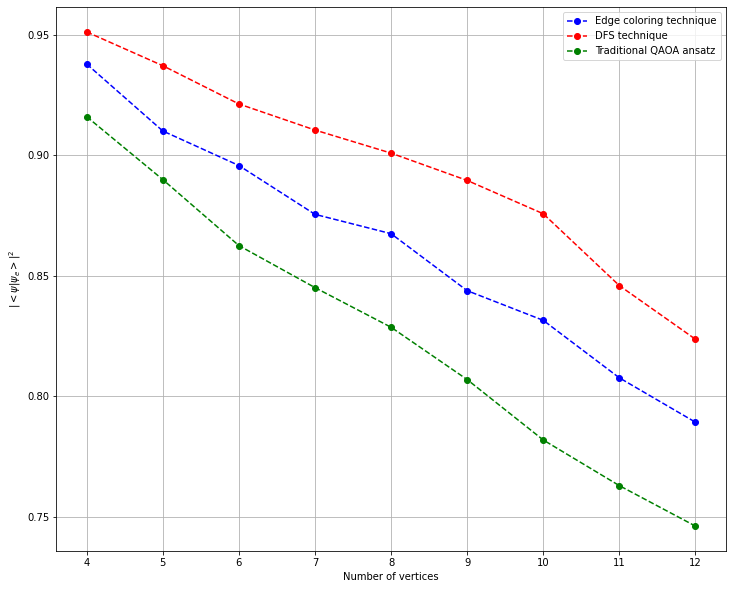

In [5]:
num_vertices = arange(4,13,1)

plt.figure(figsize=[12,10])
plt.plot(num_vertices,coloring_scheme,'bo--',label='Edge coloring technique')
plt.plot(num_vertices,dfs_scheme,'ro--',label='DFS technique')
plt.plot(num_vertices,qaoa_scheme,'go--',label='Traditional QAOA ansatz')
plt.xlabel('Number of vertices')
plt.ylabel('$|<\psi|\psi_e>|^2$')
#plt.title('Probability of error for complete graph and Manhattan noise model')
plt.grid()
plt.legend()
plt.show()